In [1]:
print("start")

start


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers

from keras.layers import LSTM, Dense, Input, Bidirectional
from keras.models import Sequential, Model
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
pd.set_option('display.max_row', 300)
pd.set_option('display.max_columns', 100)

In [4]:
data_usa = pd.read_csv("data_usa.csv", index_col = 0)
data_usa

,date,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,습도,풍속,현지기압,기온,is_holiday
0,2020-01-22,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,65.558594,7.109375,1007.415625,1.947656,0
1,2020-01-23,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,62.528125,4.953125,1003.976562,5.356250,0
2,2020-01-24,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,63.800781,5.609375,1002.466406,7.562500,0
3,2020-01-25,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,69.702344,7.265625,998.768750,8.385937,0
4,2020-01-26,3.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,74.949219,8.460938,994.538281,8.107031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,2021-06-18,20608.0,601571.0,593.0,301.571,1817.421,1.792,0.911,379999.0,461862544.0,1395.344,1.148,496530.0,1.5,0.022,45.5,316048776.0,176290249.0,148459003.0,1079390.0,1362712.0,94.50,52.71,44.39,4075.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,38.707143,7.285714,997.775000,27.167857,0
514,2021-06-19,8520.0,601741.0,170.0,285.857,1817.934,0.514,0.864,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317117797.0,176737141.0,149125164.0,1069021.0,1286438.0,94.82,52.85,44.59,3847.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,58.209524,7.547619,993.652381,26.009524,0
515,2021-06-20,3892.0,601824.0,83.0,281.857,1818.185,0.251,0.852,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317966408.0,177088290.0,149667646.0,848611.0,1234838.0,95.07,52.95,44.75,3692.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,59.037778,7.68888

# MODELING

In [5]:
df_k = data_usa.iloc[:,1:]
df_k

,new_cases,total_deaths,new_deaths,new_deaths_smoothed,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,C4_Restrictions on gatherings,C4_Flag,C5_Close public transport,C5_Flag,C6_Stay at home requirements,C6_Flag,C7_Restrictions on internal movement,C7_Flag,C8_International travel controls,E1_Income support,E1_Flag,E2_Debt/contract relief,E3_Fiscal measures,E4_International support,H1_Public information campaigns,H1_Flag,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag,M1_Wildcard,습도,풍속,현지기압,기온,is_holiday
0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,65.558594,7.109375,1007.415625,1.947656,0
1,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,62.528125,4.953125,1003.976562,5.356250,0
2,1.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,63.800781,5.609375,1002.466406,7.562500,0
3,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,69.702344,7.265625,998.768750,8.385937,0
4,3.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,9.0,0.0,9.0,9.0,74.949219,8.460938,994.538281,8.107031,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,20608.0,601571.0,593.0,301.571,1817.421,1.792,0.911,379999.0,461862544.0,1395.344,1.148,496530.0,1.5,0.022,45.5,316048776.0,176290249.0,148459003.0,1079390.0,1362712.0,94.50,52.71,44.39,4075.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,38.707143,7.285714,997.775000,27.167857,0
514,8520.0,601741.0,170.0,285.857,1817.934,0.514,0.864,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317117797.0,176737141.0,149125164.0,1069021.0,1286438.0,94.82,52.85,44.59,3847.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,58.209524,7.547619,993.652381,26.009524,0
515,3892.0,601824.0,83.0,281.857,1818.185,0.251,0.852,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,317966408.0,177088290.0,149667646.0,848611.0,1234838.0,95.07,52.95,44.75,3692.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,59.037778,7.688889,991.722222,26.500000,0
516,12388.0,602092.0,268.0,295.857,1818.995,0.810,0.894,0.0,0.0,0.000,0.

In [6]:
train_s = df_k[:-10]
test_s = df_k[-10:]
train_l = df_k[:-30]
test_l = df_k[-30:]

In [7]:
tr_x_s = train_s.iloc[:,1:]
tr_y_s = train_s.iloc[:,:1]
te_x_s = test_s.iloc[:,1:]
te_y_s = test_s.iloc[:,:1]

tr_x_l = train_l.iloc[:,1:]
tr_y_l = train_l.iloc[:,:1]
te_x_l = test_l.iloc[:,1:]
te_y_l = test_l.iloc[:,:1]

In [8]:
tr_x_s = tr_x_s.values
tr_y_s = tr_y_s.values
te_x_s = te_x_s.values
te_y_s = te_y_s.values

tr_x_l = tr_x_l.values
tr_y_l = tr_y_l.values
te_x_l = te_x_l.values
te_y_l = te_y_l.values

In [9]:
print(tr_x_s.shape)
print(tr_x_s)
# print("")
# print(te_y.shape)
# print(te_y)

(508, 61)
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00741562e+03
  1.94765625e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00397656e+03
  5.35625000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00246641e+03
  7.56250000e+00 0.00000000e+00]
 ...
 [5.98813000e+05 4.26000000e+02 3.69571000e+02 ... 9.98460526e+02
  2.49026316e+01 0.00000000e+00]
 [5.99460000e+05 6.47000000e+02 3.86286000e+02 ... 9.96309091e+02
  2.41030303e+01 0.00000000e+00]
 [5.99740000e+05 2.80000000e+02 3.72857000e+02 ... 9.93859574e+02
  2.35063830e+01 0.00000000e+00]]


In [10]:
tr_x_s_ = tr_x_s.reshape(tr_x_s.shape[0],61,1)
te_x_s_ = te_x_s.reshape(te_x_s.shape[0],61,1)
tr_x_l_ = tr_x_l.reshape(tr_x_l.shape[0],61,1)
te_x_l_ = te_x_l.reshape(te_x_l.shape[0],61,1)

In [11]:
print(tr_x_s_.shape)
print(te_x_s_.shape)

(508, 61, 1)
(10, 61, 1)


In [12]:
print(tr_x_l_.shape)
print(te_x_l_.shape)

(488, 61, 1)
(30, 61, 1)


# LSTM
## Short Term

In [24]:
K.clear_session()
model = Sequential()

model.add(LSTM(64, activation ='relu', input_shape=(61,1), return_sequences = True))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(16))
model.add(Dense(16))
model.add(Dense(8))
model.add(Dense(1))
adam = optimizers.Adam(lr = 0.05)
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 61, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 16)               

In [25]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_s_, tr_y_s, epochs = 100, batch_size = 2, verbose=1, callbacks =[early_stop])

Epoch 1/100
508/508 [==============================] - 30s 59ms/step - loss: 6808087605.2546 - mse: 6808090112.0000
Epoch 2/100
508/508 [==============================] - 29s 56ms/step - loss: 3965142436.7648 - mse: 3965142272.0000
Epoch 3/100
508/508 [==============================] - 29s 56ms/step - loss: 3839060625.6508 - mse: 3839059712.0000
Epoch 4/100
508/508 [==============================] - 28s 55ms/step - loss: 3834771062.0855 - mse: 3834771712.0000
Epoch 5/100
508/508 [==============================] - 28s 56ms/step - loss: 4050381824.7795 - mse: 4050381568.0000
Epoch 6/100
508/508 [==============================] - 29s 57ms/step - loss: 4146002824.8150 - mse: 4146004736.0000
Epoch 7/100
508/508 [==============================] - 28s 55ms/step - loss: 3954152191.0315 - mse: 3954152448.0000
Epoch 00007: early stopping


In [26]:
y_pred_s = model.predict(te_x_s_)
real_s = np.concatenate((tr_y_s, te_y_s))
forecast_s = np.concatenate((tr_y_s, y_pred_s))

In [27]:
# RMSE를 살펴 봄
RMSE_LSTM_s  = np.mean(np.sqrt((y_pred_s[:9] - te_y_s[:9]) ** 2)) 
print(RMSE_LSTM_s)

70339.47395833333


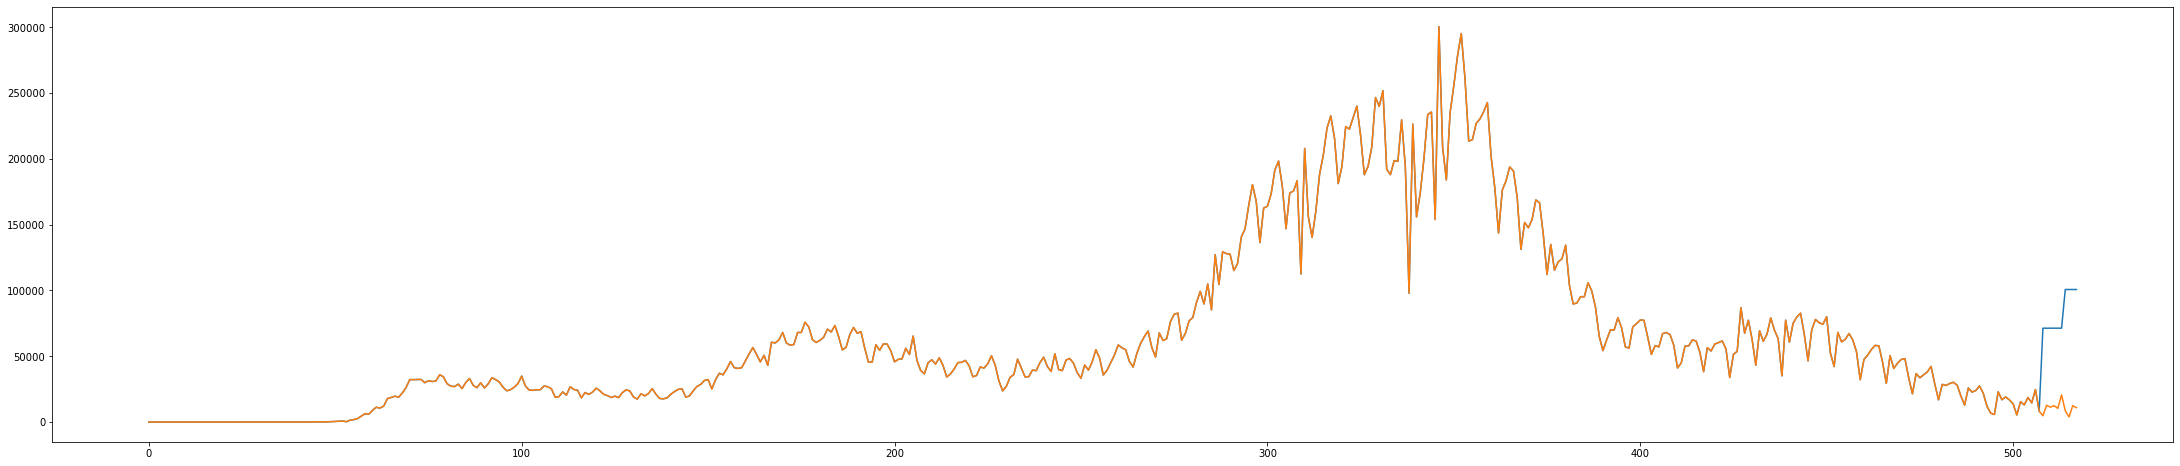

In [28]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_s, label = "forecast")
plt.plot(real_s, label = "real")
plt.legend
plt.show()

## Long term

In [27]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_l_, tr_y_l, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

Epoch 1/100
489/489 [==============================] - 16s 32ms/step - loss: 73719.0083 - mse: 73719.0000
Epoch 2/100
489/489 [==============================] - 14s 29ms/step - loss: 69787.5602 - mse: 69787.5391
Epoch 3/100
489/489 [==============================] - 14s 29ms/step - loss: 67726.7852 - mse: 67726.7969
Epoch 4/100
489/489 [==============================] - 15s 30ms/step - loss: 53634.3880 - mse: 53634.3984
Epoch 5/100
489/489 [==============================] - 15s 30ms/step - loss: 40457.5797 - mse: 40457.5781
Epoch 6/100
489/489 [==============================] - 15s 31ms/step - loss: 51368.5244 - mse: 51368.5234
Epoch 7/100
489/489 [==============================] - 15s 31ms/step - loss: 60614.0466 - mse: 60614.0469
Epoch 8/100
489/489 [==============================] - 15s 30ms/step - loss: 37416.7964 - mse: 37416.7969
Epoch 9/100
489/489 [==============================] - 14s 29ms/step - loss: 29344.8163 - mse: 29344.8164
Epoch 10/100
489/489 [========================

In [28]:
y_pred_l = model.predict(te_x_l_)
real_l = np.concatenate((tr_y_l, te_y_l))
forecast_l = np.concatenate((tr_y_l, y_pred_l))

In [29]:
# RMSE를 살펴 봄
RMSE_LSTM_l  = np.mean(np.sqrt((y_pred_l[:9] - te_y_l[:9]) ** 2)) 
print(RMSE_LSTM_l)

100.10120307074652


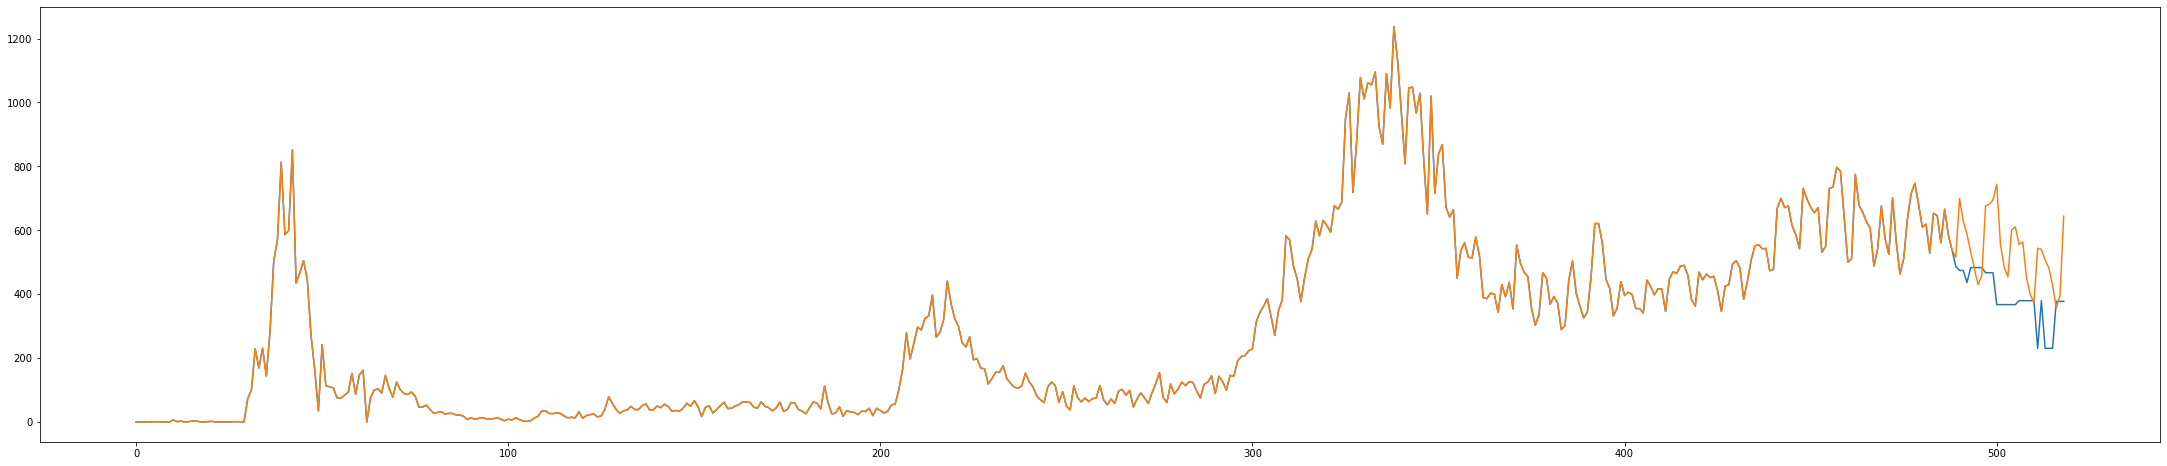

In [30]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_l, label = "forecast")
plt.plot(real_l, label = "real")
plt.legend
plt.show()

# Bidirectional LSTM

## Short Term

In [36]:
model2 = Sequential()
model2.add(Bidirectional(LSTM(64, activation='sigmoid'), input_shape=(63,1)))
model2.add(Dense(64))
model2.add(Dense(32))
model2.add(Dense(16))
model2.add(Dense(8))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 44,801
Trainable params: 44,801
Non-trainable params: 0
__________________________________________________

In [37]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model2.fit(tr_x_s_, tr_y_s, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

Epoch 1/100
509/509 [==============================] - 20s 39ms/step - loss: 94251.1821 - mse: 94251.2344
Epoch 2/100
509/509 [==============================] - 19s 36ms/step - loss: 40217.4759 - mse: 40217.4805
Epoch 3/100
509/509 [==============================] - 19s 37ms/step - loss: 25342.9423 - mse: 25342.9355
Epoch 4/100
509/509 [==============================] - 18s 36ms/step - loss: 24802.9372 - mse: 24802.9395
Epoch 5/100
509/509 [==============================] - 19s 37ms/step - loss: 22506.0637 - mse: 22506.0547
Epoch 6/100
509/509 [==============================] - 18s 35ms/step - loss: 22639.5694 - mse: 22639.5723
Epoch 7/100
509/509 [==============================] - 20s 39ms/step - loss: 21206.9191 - mse: 21206.9180
Epoch 8/100
509/509 [==============================] - 18s 35ms/step - loss: 21648.8138 - mse: 21648.8066
Epoch 9/100
509/509 [==============================] - 19s 37ms/step - loss: 21884.3839 - mse: 21884.3887
Epoch 10/100
509/509 [========================

In [38]:
y_pred_s2 = model2.predict(te_x_s_)
real_s2 = np.concatenate((tr_y_s, te_y_s))
forecast_s2 = np.concatenate((tr_y_s, y_pred_s2))

In [39]:
# RMSE를 살펴 봄
RMSE_LSTM_s2  = np.mean(np.sqrt((y_pred_s2[:9] - te_y_s[:9]) ** 2)) 
print(RMSE_LSTM_s2)

167.44401041666666


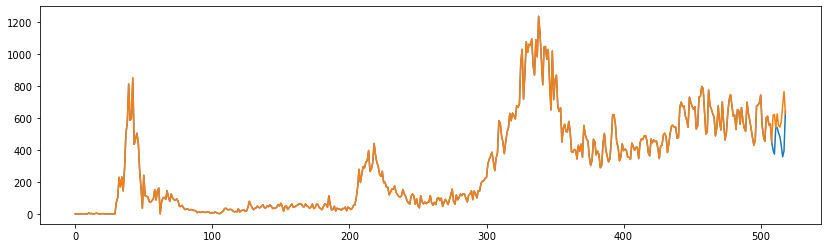

In [40]:
plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real_s2, label = "real")
plt.plot(forecast_s2, label = "forecast")
# plt.xlim([450,530])
plt.legend
plt.show()

## Long Term

In [ ]:
early_stop = EarlyStopping(monitor="loss", patience = 3, verbose=1)
model.fit(tr_x_l_, tr_y_l, epochs = 100, batch_size = 3, verbose=1, callbacks =[early_stop])

In [ ]:
y_pred_l = model.predict(te_x_l_)
real_l = np.concatenate((tr_y_l, te_y_l))
forecast_l = np.concatenate((tr_y_l, y_pred_l))

In [ ]:
# RMSE를 살펴 봄
RMSE_LSTM_l  = np.mean(np.sqrt((y_pred_l[:9] - te_y_l[:9]) ** 2)) 
print(RMSE_LSTM_l)

In [ ]:
plt.rcParams["figure.figsize"] = (38,8)
plt.plot(forecast_l, label = "forecast")
plt.plot(real_l, label = "real")
plt.legend
plt.show()

# ARIMA

## Short Term

In [120]:
from pylab import rcParams
import statsmodels.api as sm
import warnings
import itertools
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [121]:
a_df_k = data_usa.iloc[:,:2]
a_df_k['date'] =  pd.to_datetime(a_df_k['date'])
a_df_k=a_df_k.set_index('date')
a_df_k

,new_cases
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,3.0
...,...
2021-06-18,20608.0
2021-06-19,8520.0
2021-06-20,3892.0


In [122]:
case_by_day = a_df_k.new_cases.resample('d').sum()
split = "2021-06-12"
a_kr_train = case_by_day[:split]
a_kr_test = case_by_day[split:]
a_kr_final = a_kr_test.copy()

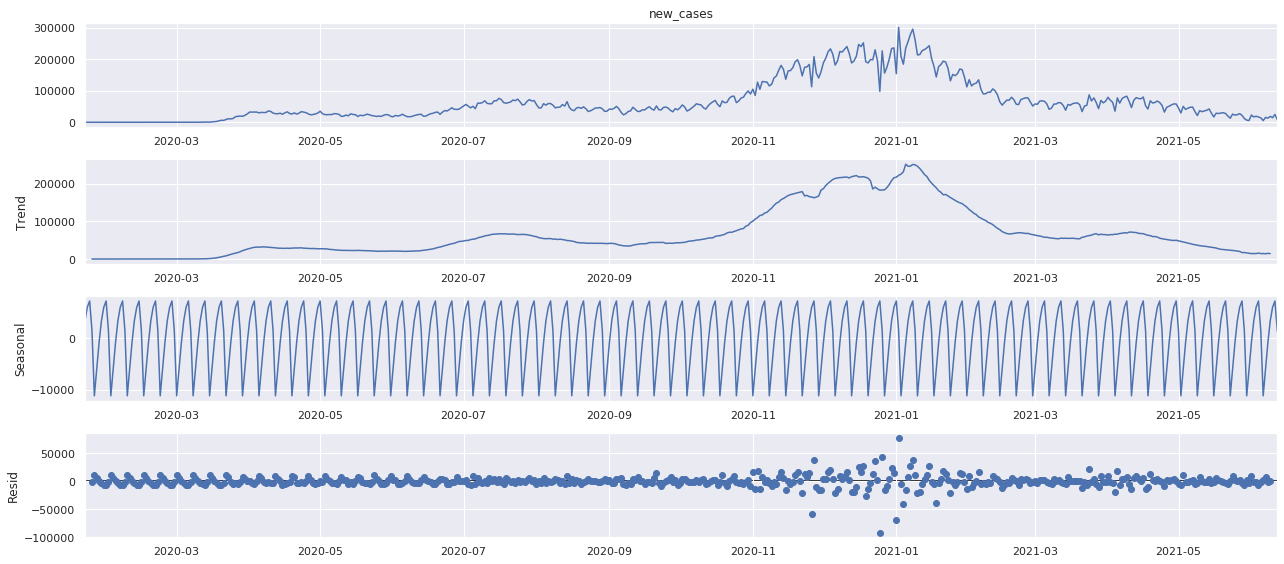

In [123]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a_kr_train, model='additive')
fig = decomposition.plot()
plt.show()

In [124]:
#p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(a_kr_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13030.271129215318
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:12441.593490902873
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11611.789696513548
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11344.099102388409
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11623.24227034663
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11602.593192844812
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11366.507040934493
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11344.24976020306
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:12666.972671420228
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12295.433855522158
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11443.52945214416
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11162.725191845204
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12290.917150982668
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:12242.622092391042
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11205.589874938914
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11162.958649035741
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11322.931969926376
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11065.14318024

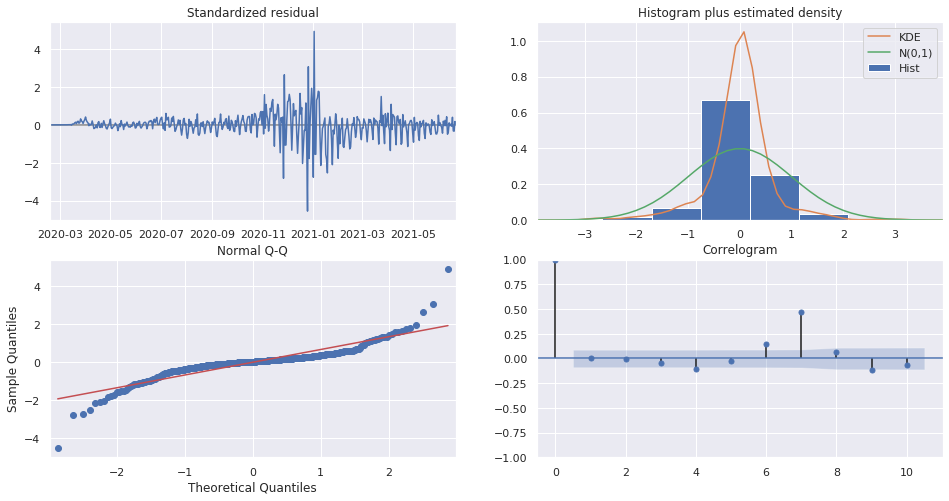

In [125]:
NEW_CASES  = sm.tsa.statespace.SARIMAX(case_by_day , order=(1, 1, 1), seasonal_order=(0, 1, 1, 12) , enforce_stationarity = False, enforce_invertibility = False)

SARIMA_results_day = NEW_CASES.fit()

SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [126]:
SARIMA_predict_day = SARIMA_results_day.predict(start=len(case_by_day)-10, end=len(case_by_day))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
a_kr_final['predicted'] = SARIMA_predict_day


In [127]:
# RMSE를 살펴 봄
RMSE_daily_ARIMA  = np.mean(np.sqrt((SARIMA_predict_day - a_kr_test) ** 2)) 
print(RMSE_daily_ARIMA)

4384.484609247408


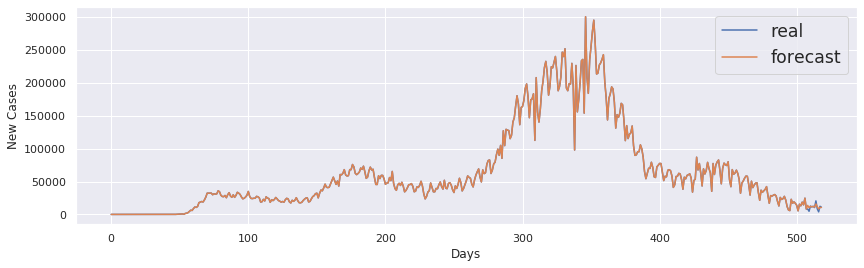

In [128]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

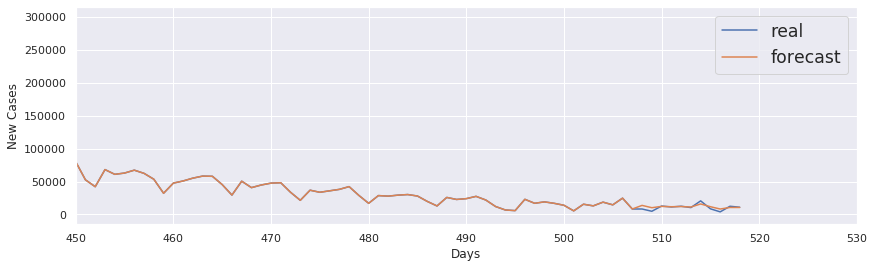

In [129]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

## Long Term

In [130]:
case_by_day = a_df_k.new_cases.resample('d').sum()
split = "2021-05-23"
a_kr_train = case_by_day[:split]
a_kr_test = case_by_day[split:]
a_kr_final = a_kr_test.copy()


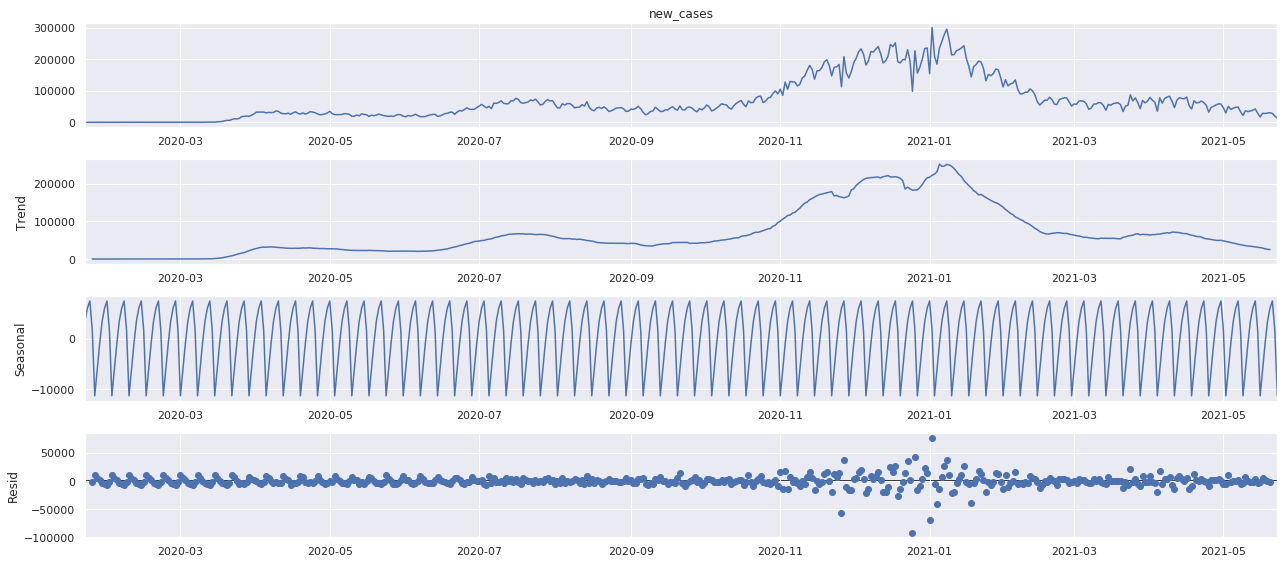

In [131]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a_kr_train, model='additive')
fig = decomposition.plot()
plt.show()

In [132]:
#p,d,q의 조합을 만들어 하나하나 ARIMA 모델을 돌려봄
p = d = q = range(0, 2)

import itertools
pdqa = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdqa:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(a_kr_train, order = param, seasonal_order = param_seasonal, enforce_stationarity = False, enforce_invertibility = False)                                
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:12535.192549860167
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:11958.274478196989
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11158.84858568268
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10890.7462505621
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11171.29244742951
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11150.672071286837
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:10913.178719978312
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10891.184687074188
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:12185.055070215138
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:11816.255415709453
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:10996.897475278904
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10715.86954792447
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11814.0079057347
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11765.64847073024
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10758.908287884253
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10716.202966466597
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:10890.947118276383
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10632.952471019635


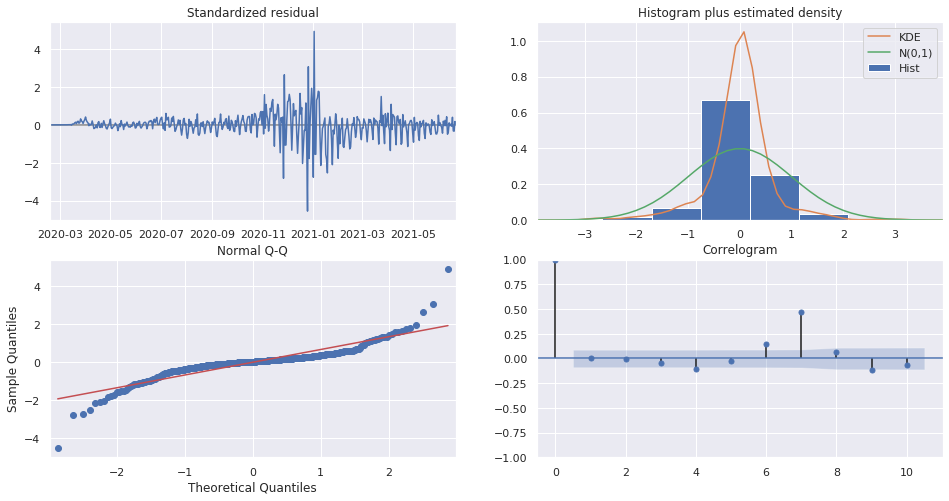

In [133]:
NEW_CASES  = sm.tsa.statespace.SARIMAX(case_by_day , order=(1, 1, 1), seasonal_order=(0, 1, 1, 12) , enforce_stationarity = False, enforce_invertibility = False)

SARIMA_results_day = NEW_CASES.fit()

SARIMA_results_day.plot_diagnostics(figsize=(16, 8))
plt.show()

In [134]:
SARIMA_predict_day = SARIMA_results_day.predict(start=len(case_by_day)-30, end=len(case_by_day))

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
a_kr_final['predicted'] = SARIMA_predict_day


In [135]:
# RMSE를 살펴 봄
RMSE_daily_ARIMA  = np.mean(np.sqrt((SARIMA_predict_day - a_kr_test) ** 2)) 
print(RMSE_daily_ARIMA)

5070.142569611349


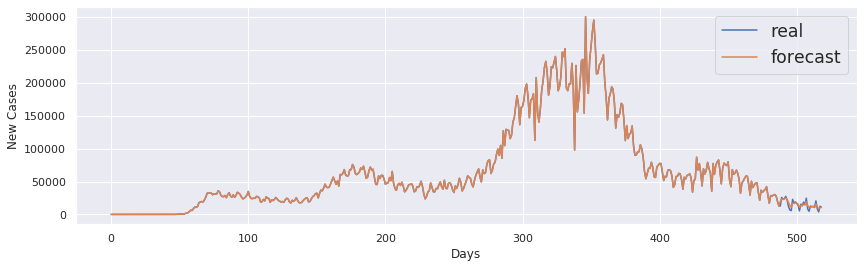

In [136]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

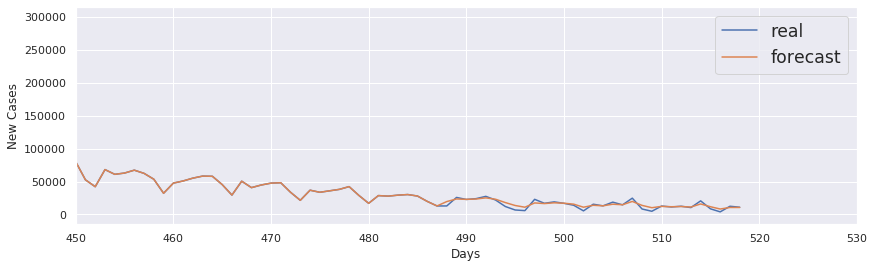

In [137]:
# test 데이터와 예측 결과치를 비교

real3 = np.concatenate((a_kr_train, a_kr_test))
forecast3 = np.concatenate((a_kr_train, SARIMA_predict_day))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real3, label = "real")
plt.plot(forecast3, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

# Vector Auto Regression (VAR)

## Short Term

In [205]:
df_temp_usa = data_usa.iloc[:, 2:]
df_out_usa = []
for col in df_temp_usa.columns.tolist():
    if(type(df_temp_usa[col]) != "str"):
        tau, p_value = stats.kendalltau(data_usa['new_cases'], df_temp_usa[col])
        df_out_usa.append([np.abs(tau), p_value, col])

In [206]:
def Sort(sub_li):
    return(sorted(sub_li, key = lambda x: x[0])) 

In [207]:
sorted_out = Sort(df_out_usa)
sorted_out[-20:]

[[0.37383370198840343, 1.39188650889134e-25, 'C1_Flag'],
 [0.381051618332909, 1.4603162862981052e-26, 'E2_Debt/contract relief'],
 [0.3816102352831376, 9.099801916004444e-28, 'C6_Flag'],
 [0.39144258415560973, 4.0015562089024405e-40, 'total_tests'],
 [0.39144258415560973, 4.0015562089024405e-40, 'total_tests_per_thousand'],
 [0.4279302659093202, 5.418717100177574e-47, 'positive_rate'],
 [0.4405667601443008, 1.904363952838973e-34, 'C4_Flag'],
 [0.45858097748971577, 3.530401150805131e-37, 'H1_Flag'],
 [0.4688807579839367, 1.2225533242561873e-43, 'H6_Facial Coverings'],
 [0.4860735939134099, 1.4791264317296894e-41, 'H6_Flag'],
 [0.5419920801110408, 2.55238007932263e-75, 'new_deaths_smoothed_per_million'],
 [0.5423721157351132, 1.800331688307494e-75, 'new_deaths_smoothed'],
 [0.5474136159036442, 8.314537601050521e-77, 'new_deaths'],
 [0.5474136159036442, 8.314537601050521e-77, 'new_deaths_per_million'],
 [0.5545006892069086, 9.310605053097031e-55, 'E1_Flag'],
 [0.7227665635745276, 2.315947

In [208]:
raw_usa = data_usa[['new_cases','positive_rate','H6_Facial Coverings','total_deaths_per_million','new_tests_smoothed_per_thousand']]
raw_usa

,new_cases,positive_rate,H6_Facial Coverings,total_deaths_per_million,new_tests_smoothed_per_thousand
0,0.0,0.000,0.0,0.000,0.0
1,0.0,0.000,0.0,0.000,0.0
2,1.0,0.000,0.0,0.000,0.0
3,0.0,0.000,0.0,0.000,0.0
4,3.0,0.000,0.0,0.000,0.0
...,...,...,...,...,...
513,20608.0,0.022,9.0,1817.421,1.5
514,8520.0,0.000,9.0,1817.934,0.0
515,3892.0,0.000,9.0,1818.185,0.0
516,12388.0,0.000,9.0,1818.995,0.0


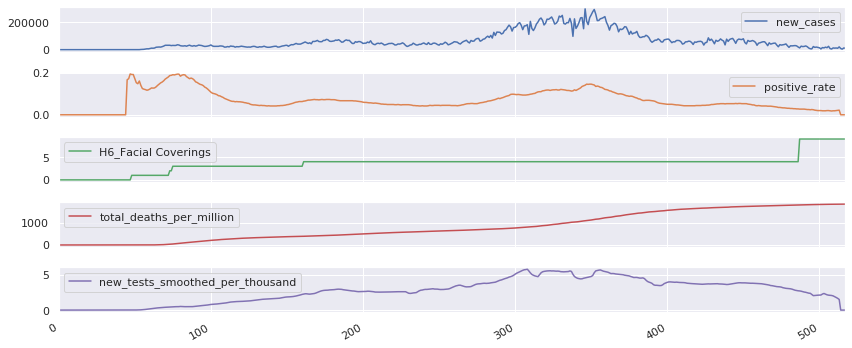

In [209]:
# 데이터 시각화
raw_usa.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [210]:
adfuller_test = adfuller(raw_usa['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.6740658544269118
p-value: 0.44452161307830573


In [211]:
adfuller_test = adfuller(raw_usa['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.1910332167549345
p-value: 0.20951596361606317


In [212]:
adfuller_test = adfuller(raw_usa['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -0.8448218139520831
p-value: 0.8056002856956415


In [213]:
adfuller_test = adfuller(raw_usa['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -1.159449073769539
p-value: 0.6907920702298351


In [214]:
adfuller_test = adfuller(raw_usa['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -0.6456105608081195
p-value: 0.860339351010833


In [215]:
raw_usa_diff = raw_usa.diff().dropna()


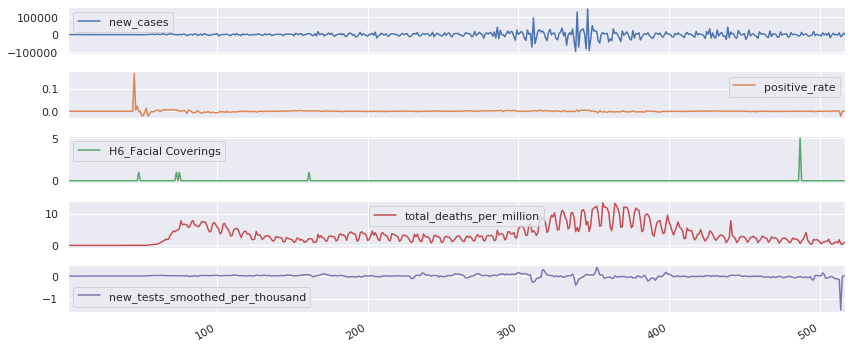

In [216]:
raw_usa_diff.plot(subplots=True, figsize=(12,5))
plt.tight_layout()
plt.show()

In [217]:
adfuller_test = adfuller(raw_usa_diff['new_cases'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -4.738749767404624
p-value: 7.11238195473618e-05


In [218]:
adfuller_test = adfuller(raw_usa_diff['positive_rate'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -7.939179052369546
p-value: 3.349615685275179e-12


In [219]:
adfuller_test = adfuller(raw_usa_diff['total_deaths_per_million'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -2.2158229535979372
p-value: 0.20055284019246533


In [220]:
adfuller_test = adfuller(raw_usa_diff['new_tests_smoothed_per_thousand'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -3.444085301677368
p-value: 0.009544728227755542


In [221]:
adfuller_test = adfuller(raw_usa_diff['H6_Facial Coverings'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -22.795294602602898
p-value: 0.0


In [222]:
train = raw_usa_diff.iloc[:-10,:]
test = raw_usa_diff.iloc[-10:,:]

In [223]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


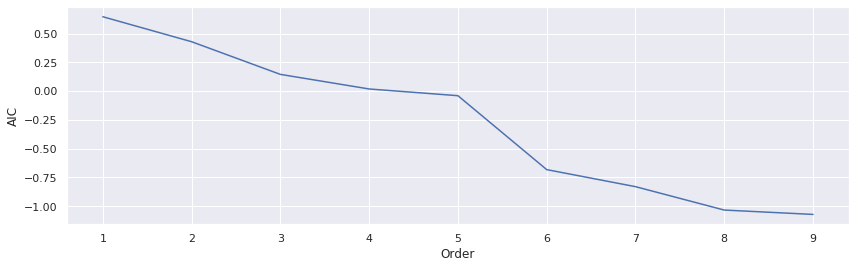

In [224]:
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [225]:
results = forecasting_model.fit(9)
# results.summary()

In [226]:
laaged_values = train.values[-9:]

In [227]:
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['new_cases_diff','positive_rate_diff','H6_Facial Coverings_diff','total_deaths_per_million_diff','new_tests_smoothed_per_thousand_diff'])
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff
508,5960.133114,0.001352,0.071314,0.975438,-0.001981
509,10440.551510,0.001530,0.099864,1.315682,-0.013531
510,-1930.121074,0.002847,0.033076,1.679172,0.026394
511,1214.001765,0.001437,-0.016222,2.117730,0.067578
512,3383.618357,0.001349,0.019140,1.935046,0.038845
513,1777.037038,0.001612,0.054637,1.662724,0.006902
514,-4996.871543,0.000995,0.034459,1.284271,0.017689
515,1577.636322,0.000412,0.039577,1.147093,0.031335
516,1974.665272,0.000899,0.021367,1.592796,0.024248
517,1328.682123,0.000691,0.027377,1.864208,0.004541


In [228]:
forecast["new_cases_forecasted"] = raw_kor["new_cases"].iloc[-10-1] + forecast['new_cases_diff'].cumsum()
forecast["positive_rate_forecasted"] = raw_kor["positive_rate"].iloc[-10-1] + forecast['positive_rate_diff'].cumsum()
forecast["total_deaths_per_million_forecasted"] = raw_kor["total_deaths_per_million"].iloc[-10-1] + forecast['total_deaths_per_million_diff'].cumsum()
forecast["new_tests_smoothed_per_thousand_forecasted"] = raw_kor["new_tests_smoothed_per_thousand"].iloc[-10-1] + forecast['new_tests_smoothed_per_thousand_diff'].cumsum()

forecast["H6_Facial Coverings_forecasted"] = raw_kor["H6_Facial Coverings"].iloc[-10-1] + forecast['H6_Facial Coverings_diff'].cumsum()
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff,new_cases_forecasted,positive_rate_forecasted,total_deaths_per_million_forecasted,new_tests_smoothed_per_thousand_forecasted,H6_Facial Coverings_forecasted
508,5960.133114,0.001352,0.071314,0.975438,-0.001981,14188.133114,0.020352,1812.864438,2.075019,9.071314
509,10440.551510,0.001530,0.099864,1.315682,-0.013531,24628.684624,0.021882,1814.180120,2.061488,9.171178
510,-1930.121074,0.002847,0.033076,1.679172,0.026394,22698.563550,0.024728,1815.859293,2.087882,9.204254
511,1214.001765,0.001437,-0.016222,2.117730,0.067578,23912.565315,0.026166,1817.977022,2.155461,9.188033
512,3383.618357,0.001349,0.019140,1.935046,0.038845,27296.183672,0.027515,1819.912069,2.194306,9.207172
513,1777.037038,0.001612,0.054637,1.662724,0.006902,29073.220710,0.029127,1821.574793,2.201208,9.261810
514,-4996.871543,0.000995,0.034459,1.284271,0.017689,24076.349167,0.030122,1822.859063,2.218897,9.296269
515,1577.636322,0.000412,0.039577,1.147093,0.031335,25653.985489,0.030534,1824.006156,2.250232,9.335846
516,1974.665272,0.000899,0.021367,1.592796,0.024248,27628.650760,0.031433,1825.598952,2.274480,9.357213
517,1328.682123,0.000691,0.027377,1.864208,0.004541,28957.332883,0.032123,1827.463160,2.279021,9.384590


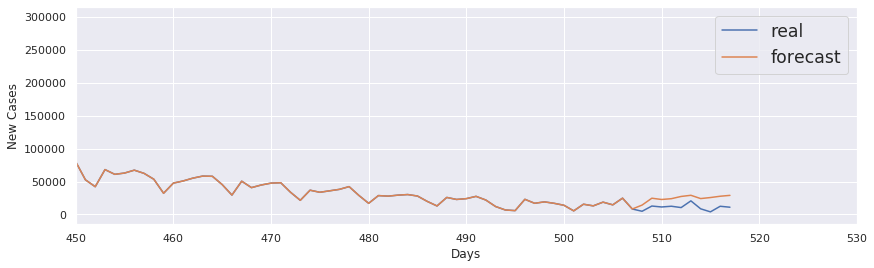

In [229]:
# train = raw_kor.iloc[:-10,:]
real4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], raw_kor.iloc[-10:,:]['new_cases']))
forecast4 = np.concatenate((raw_kor.iloc[:-10,:]['new_cases'], forecast["new_cases_forecasted"]))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real4, label = "real")
plt.plot(forecast4, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

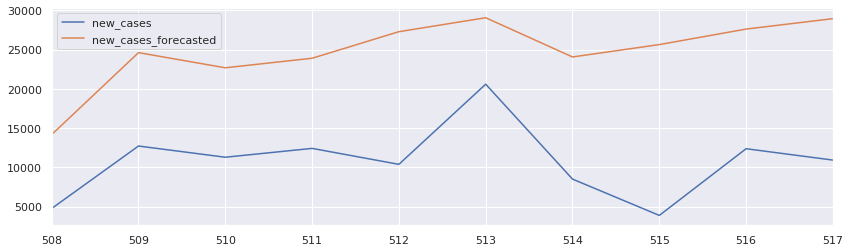

In [230]:
test = raw_kor.iloc[-10:,:1]
test["new_cases_forecasted"] = forecast["new_cases_forecasted"]

test.plot()

In [231]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], test['new_cases_forecasted']))
rmse

14565.396899721172

## Long Term


In [165]:
train = raw_usa_diff.iloc[:-30,:]
test = raw_usa_diff.iloc[-30:,:]

In [166]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


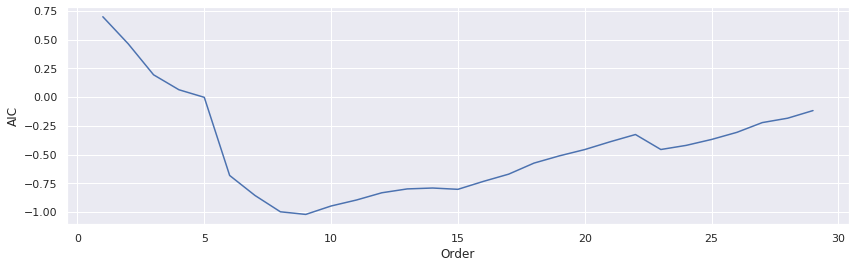

In [167]:
sns.set()
plt.plot(list(np.arange(1,30,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [168]:
results = forecasting_model.fit(9)
# results.summary()

In [169]:
laaged_values = train.values[-9:]

In [170]:
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=30), index = test.index, columns= ['new_cases_diff','positive_rate_diff','H6_Facial Coverings_diff','total_deaths_per_million_diff','new_tests_smoothed_per_thousand_diff'])
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff
488,17216.629670,-0.011825,-0.203774,7.104953,0.025012
489,-15953.382999,-0.002735,1.699387,6.303638,-0.025433
490,12268.160747,-0.004860,-0.336100,7.984496,-0.072486
491,-4094.975246,-0.004048,-0.221200,4.681454,-0.023079
492,-10959.541797,-0.002914,-0.211957,4.979445,0.059410
493,15451.271072,0.005880,-0.120965,5.276176,-0.016251
494,-28860.199488,-0.030453,-0.194719,2.727875,0.026002
495,25973.586791,0.004325,-0.195545,6.591065,0.010342
496,-2052.884409,-0.015863,0.046126,8.177712,0.078471
497,6780.192936,0.002674,-0.313918,7.267168,0.090898


In [171]:
forecast["new_cases_forecasted"] = raw_kor["new_cases"].iloc[-30-1] + forecast['new_cases_diff'].cumsum()
forecast["positive_rate_forecasted"] = raw_kor["positive_rate"].iloc[-30-1] + forecast['positive_rate_diff'].cumsum()
forecast["total_deaths_per_million_forecasted"] = raw_kor["total_deaths_per_million"].iloc[-30-1] + forecast['total_deaths_per_million_diff'].cumsum()
forecast["new_tests_smoothed_per_thousand_forecasted"] = raw_kor["new_tests_smoothed_per_thousand"].iloc[-30-1] + forecast['new_tests_smoothed_per_thousand_diff'].cumsum()

forecast["H6_Facial Coverings_forecasted"] = raw_kor["H6_Facial Coverings"].iloc[-30-1] + forecast['H6_Facial Coverings_diff'].cumsum()
forecast

,new_cases_diff,positive_rate_diff,H6_Facial Coverings_diff,total_deaths_per_million_diff,new_tests_smoothed_per_thousand_diff,new_cases_forecasted,positive_rate_forecasted,total_deaths_per_million_forecasted,new_tests_smoothed_per_thousand_forecasted,H6_Facial Coverings_forecasted
488,17216.629670,-0.011825,-0.203774,7.104953,0.025012,30082.629670,0.015175,1789.114953,2.727012,8.796226
489,-15953.382999,-0.002735,1.699387,6.303638,-0.025433,14129.246671,0.012440,1795.418591,2.701579,10.495613
490,12268.160747,-0.004860,-0.336100,7.984496,-0.072486,26397.407418,0.007580,1803.403087,2.629093,10.159513
491,-4094.975246,-0.004048,-0.221200,4.681454,-0.023079,22302.432173,0.003532,1808.084541,2.606014,9.938313
492,-10959.541797,-0.002914,-0.211957,4.979445,0.059410,11342.890376,0.000618,1813.063986,2.665424,9.726356
493,15451.271072,0.005880,-0.120965,5.276176,-0.016251,26794.161448,0.006498,1818.340163,2.649173,9.605391
494,-28860.199488,-0.030453,-0.194719,2.727875,0.026002,-2066.038040,-0.023955,1821.068038,2.675175,9.410672
495,25973.586791,0.004325,-0.195545,6.591065,0.010342,23907.548751,-0.019630,1827.659103,2.685517,9.215126
496,-2052.884409,-0.015863,0.046126,8.177712,0.078471,21854.664341,-0.035493,1835.836815,2.763988,9.261253
497,6780.192936,0.002674,-0.313918,7.267168,0.090898,28634.857277,-0.032819,1843.103983,2.854886,8.947334


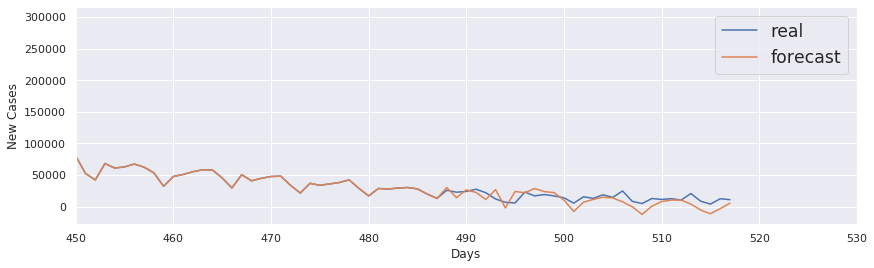

In [172]:
# train = raw_kor.iloc[:-10,:]
real4 = np.concatenate((raw_kor.iloc[:-30,:]['new_cases'], raw_kor.iloc[-30:,:]['new_cases']))
forecast4 = np.concatenate((raw_kor.iloc[:-30,:]['new_cases'], forecast["new_cases_forecasted"]))

plt.rcParams["figure.figsize"] = (14,4)
plt.plot(real4, label = "real")
plt.plot(forecast4, label = "forecast")
plt.xlim([450,530])
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend(fontsize='x-large')
plt.show()

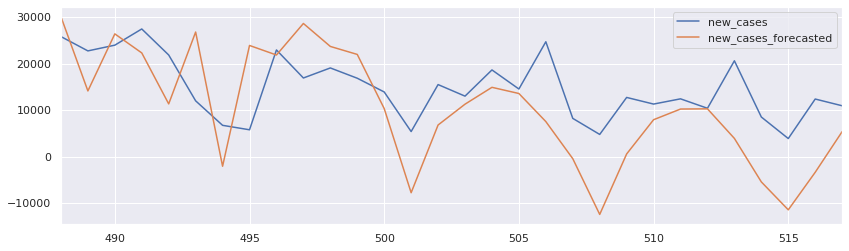

In [173]:
test = raw_kor.iloc[-30:,:1]
test["new_cases_forecasted"] = forecast["new_cases_forecasted"]

test.plot()

In [174]:
rmse = np.sqrt(mean_squared_error(test['new_cases'], test['new_cases_forecasted']))
rmse

10234.492405970961